# GTZAN Dataset Music Genre Classification

This notebook uses the [GTZAN Dataset](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) to train three basic machine learning algorithms on audio features, focusing on how different models learn from simple statistical representations of audio. The algorithms will be able to classify between two distinct genres when given two measured audio features.

The goal is to build intuition for designing models that can classify nuanced audio data, a step toward dialect-aware TTS models.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from ml_algorithms import *

GTZAN_FILE_PATH = "./data/features_30_sec.csv"

assert os.path.exists(GTZAN_FILE_PATH), f"File not found: {GTZAN_FILE_PATH}"

### Loading Data

From the GTZAN Dataset, a benchmark for genre classification. While GTZAN contains music genres, this experiment uses it as a stand-in for dialect or audio-style classification to develop methods applicable to dialect-aware TTS. We use the `features_30_sec.csv` file containing a mean and variance computed over mulitple features that can be extracted from an audio file.

In [137]:
def load_data(file_path: str) -> pd.DataFrame:
    try:
        data = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()


df = load_data(GTZAN_FILE_PATH)
df.head()

Data loaded successfully from ./data/features_30_sec.csv


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


## Clean Data

For the purposes of this analysis, we filter the dataset to include only:

`chroma_stft_mean | rms_mean | label`

where `label` is the music genre

We will also only filter records to include only `classical` or `metal` label as they have distinct audio features from each other and will simplify the problem into binary classification. This controlled setup helps observe how simple models react to distinct audio features, reflecting on potential challenges in binary dialect classification

In [138]:
def clean_data(
    df: pd.DataFrame, features_to_keep: list, targets_to_keep: list
) -> pd.DataFrame:
    features = features_to_keep.copy()
    features.append("label")
    if df.empty:
        print("DataFrame is empty.")
        return df
    df = df[df["label"].isin(targets_to_keep)]
    df = df[features]
    return df.reset_index(drop=True)


features = [
    "chroma_stft_mean",
    "rms_mean",
]
targets = ["classical", "metal"]

df = clean_data(df, features, targets)
df.head()

,chroma_stft_mean,rms_mean,label
0,0.252392,0.036245,classical
1,0.214995,0.030625,classical
2,0.277958,0.043860,classical
3,0.234229,0.029442,classical
4,0.221574,0.042316,classical


## Select Features and Targets

We select two audio features:
- **Chroma STFT Mean**: capturing pitch class energy over time
- **Root Mean Square (RMS) Energy Mean**: measuring audio loudness

These features serve as a proxy for dialectal features like pitch variation or speech energy, offering insight into what simple features might (or might not) reveal in dialect-aware classification

In [139]:
def select_targets(df: pd.DataFrame) -> np.ndarray:
    y = df["label"].values
    y = np.where(y == targets[0], 0, 1)  # -> 1 if classical, else 0 (aka metal)
    return y


def select_features(df: pd.DataFrame, features: list) -> np.ndarray:
    X = df[features].values
    return X


def standardize_features(X) -> np.ndarray:
    X_std = np.copy(X)
    X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
    X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
    return X_std


y = select_targets(df)
X = select_features(df, features)

# Features standardized for use in the Adaline models
X_std = standardize_features(X)

## Plotting Root Mean Squared vs Chroma STFT (Unaltered Data)

A scatterplot visualizes the two classes across the selected features, giving a baseline sense of separability.

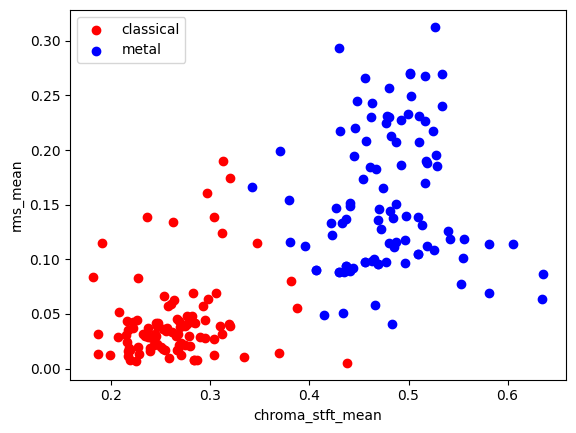

In [140]:
plt.scatter(X[:100, 0], X[:100, 1], color="r", marker="o", label=targets[0])
plt.scatter(X[100:, 0], X[100:, 1], color="b", marker="o", label=targets[1])
plt.xlabel(features[0])
plt.ylabel(features[1])
plt.legend(loc="upper left")
plt.show()

In [141]:
# Plotting functions used to plot the output of the models


def plot_epochs(errors, ylabel, title):
    plt.plot(range(1, len(errors) + 1), errors, marker="o")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)


def plot_decision_regions(X, y, classifier, padding, title, resolution=0.001):
    markers = ("o", "s", "^", "v", "<")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[: len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    x2_min, x2_max = X[:, 1].min() - padding, X[:, 1].max() + padding
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution)
    )
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f"Class {cl} ({targets[idx]})",
            edgecolor="black",
        )

    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.title(title)
    plt.legend(loc="upper left")

## Training Perceptron
We train a **Perceptron**, a basic linear classifier using misclassifcication-based updates on the raw features

In [142]:
ppn = Perceptron(eta=0.001, n_epoch=200)


def train_perceptron(X, y):
    ppn.fit(X, y)


train_perceptron(X, y)

### Graphing Perceptron

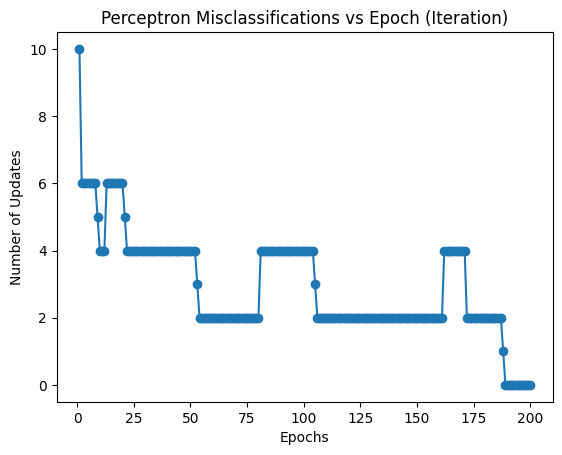

In [143]:
plot_epochs(
    ppn.errors_,
    "Number of Updates",
    "Perceptron Misclassifications vs Epoch (Iteration)",
)

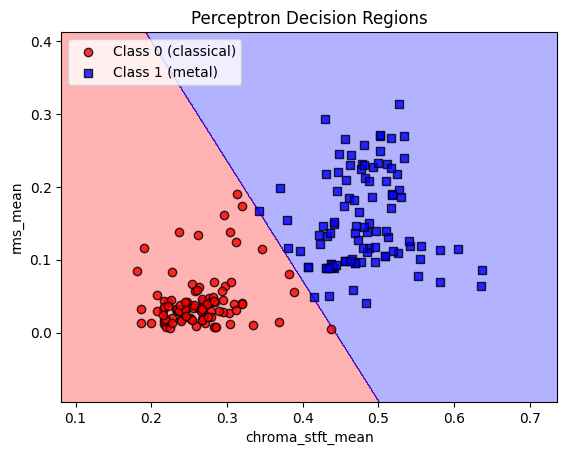

In [144]:
plot_decision_regions(X, y, ppn, 0.1, "Perceptron Decision Regions")

### Analysis
- The perceptron required **nearly 190** epochs to minimize misclassifications with some fluctuation, far more than either Adaline model
- It achieved **a perfectly accurate decision boundary**, indicating the data is indeed linearly separable
- This suggests that while the perceptron can reach a perfect classification, its learning process is less stable and slower compared to the gradient-based methods

## Training Adaline Batch Gradient Descent (BGD)
We train **Adaline with Batch Gradient Descent**, which updates weights based on continuous error rather than discrete classification. Features are standardized beforehand.

In [145]:
ada_bgd = AdalineBGD(eta=0.5, n_epoch=20)


def train_AdalineBGD(X, y):
    ada_bgd.fit(X, y)


train_AdalineBGD(X_std, y)

### Graphing Adaline BGD

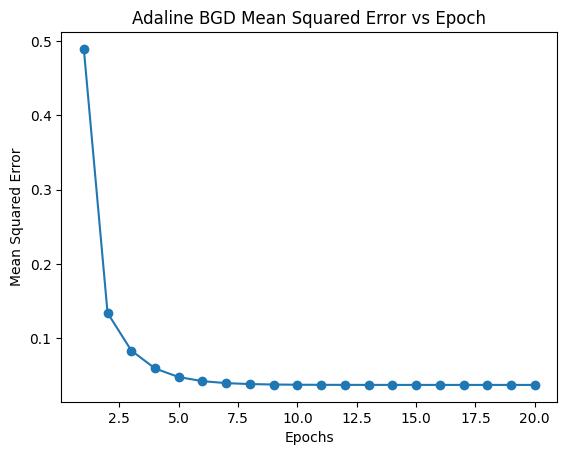

In [146]:
plot_epochs(
    ada_bgd.losses_, "Mean Squared Error", "Adaline BGD Mean Squared Error vs Epoch"
)

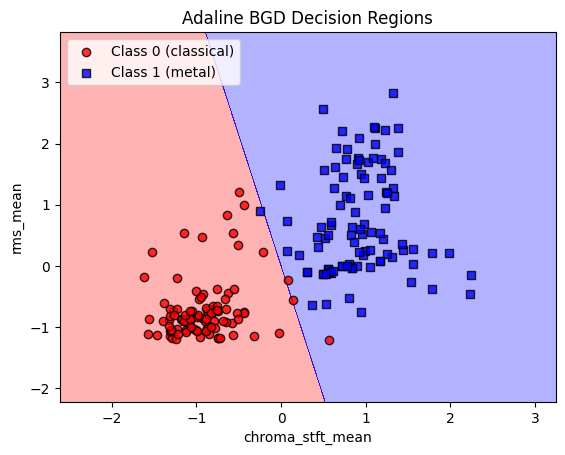

In [147]:
plot_decision_regions(X_std, y, ada_bgd, 1, "Adaline BGD Decision Regions")

### Analysis
- Adaline BGD reached near-minimum MSE in about **10 epochs**, with a smooth MSE decline
- The decision boundary was slightly off as there were a few misclassifications
- The BGD had a faster, stable, smoother convergence with slight compromise on classification precision

## Training Adaline Stochastic Gradient Descent (SGD)
We train **Adaline with Stochastic Gradient Descent**, updating weights after each training example

In [148]:
ada_sgd = AdalineSGD(eta=0.01, n_epoch=10)


def train_AdalineSGD(X, y):
    ada_sgd.fit(X, y)


train_AdalineSGD(X_std, y)

### Graphing Adaline SGD

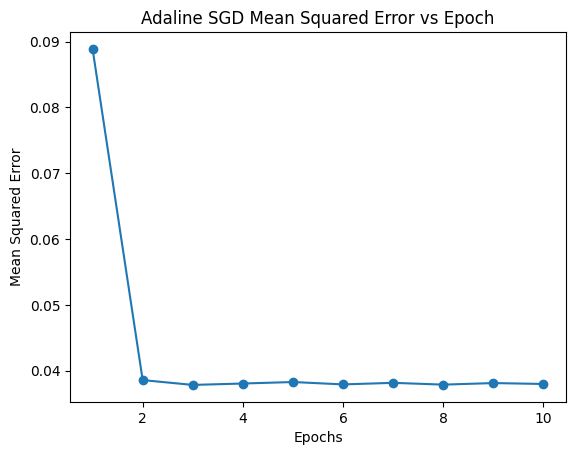

In [149]:
plot_epochs(
    ada_sgd.losses_, "Mean Squared Error", "Adaline SGD Mean Squared Error vs Epoch"
)

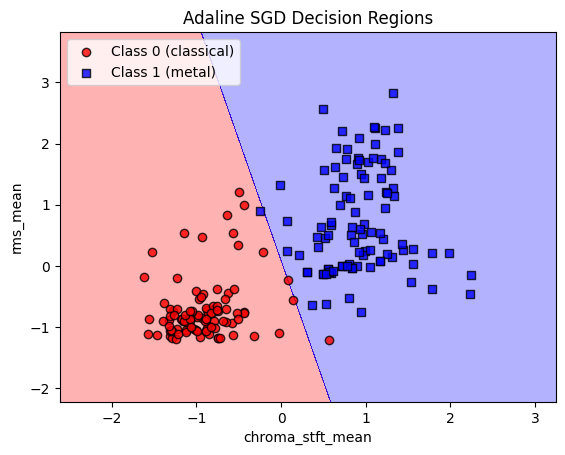

In [150]:
plot_decision_regions(X_std, y, ada_sgd, 1, "Adaline SGD Decision Regions")

### Analysis
- Adaline SGD converged in only approx. **2 epochs** with minor oscillation after, typical of SGD due to noise from single-sample updates
- Like BGD, the decision boundary was very close to correct
- The SGD was very fast, potentially valuable for large datasets, but comes with a need for techniques to control post-convergence oscillations

# Summary
This experiment compared three simple linear classifiers on GTZAN audio features:
- **Perceptron** converged slowly but achieved perfect classification once trained
- **Adaline BGD** converged quickly with smooth leraning but produced a slightly imperfect boundary
- **Adaline SGD** converged fastest but showed post-convergence fluctuations, with a similar imperfect boundary

These models highlight a key trade-off:
- Models with faster convergence may sacrifice boundary precision
- The perceptron can achieve perfect separation with linearly separable classes but with less efficient learning

For dialect-aware TTS, this underscores that both **model choice** and **training dynamics** matter, particularly when classifying subtle audio features where precision is critical

## Future Work
- Explore nonlinear models like logistic regression or neural nets for better boundary detection
- Extract richer audio features such as MFCCs relevant to dialects
- Experiment on dialectal datasets to validate model behavior beyond music genres
- Investigate deep learning architectures for scalable, precise dialect classification